# "Global Biodiversity" Widget

This widget is a horizontally oriented histogram, breaking sub regions into buckets of 'Very High' to 'Very Low' Intactness or Significance.

Due to the heavily qualitative nature of the data we are unable to quote any numerical values, nor make direct comparisons between subregions.

In the face of that the histogram will only display the percentage of subregions that fall into each bucket as a percentage.

Along side the histogram 

User Variables:

1. Global, Admin-0 and -1, -2
2. number of subregions or %
3. Biodiversity Intactness or Significance

On click:

When a user clicks on a bar the dynamic sentence should change to reflect the value of the bar.

Tabs: ['Conservation']

## Visualisation

Roughly speaking, the widget should have a horizontal bar chart and an alphabetic list of sub regions.

See [here](https://basecamp.com/3063126/projects/10727890/todos/350432223?enlarge=342718317#attachment_342718317) for a rough mock-up of the design.

### Global

At the global level the widget should take each country (iso) and calculate it's average significance or intactness (value / area).

Then calculate percentiles of these values in order to define boundaries for categorisation.

It should then categorise the countries by that average value in to the following: *High, Medium-high, Medium Medium-low, Low*.

Each bar is then the number of countries within that category.

There should also be click-interaction for each bar in the chart. Clicking on a category will display an alphabetical list of the countries that belong to that category.


### Country

The same process as the above except for the Admin 1 regions within the selected country.

### Admin 1

The same process again except for the Admin 2 regions within the selected Admin 1.

### Admin 2

Same as above, but instead, the sentence should make a statement about that area's level of significance or intactness. 

In [3]:
import os
import ee
import json
import requests
import requests_cache
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics as stats

ee.Initialize()

In [4]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [120]:
# Fetch all data

sql = (f"SELECT iso, adm1, adm2, area, "
       "significance_total AS sig, intactness_total AS int "
       f"FROM global_biodiversity_table ")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
data = r.json().get('rows')

data[0]

https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1%2C+adm2%2C+area%2C+significance_total+AS+sig%2C+intactness_total+AS+int+FROM+global_biodiversity_table+ 



{'adm1': -9999,
 'adm2': -9999,
 'area': 183049541.454811,
 'int': 0,
 'iso': 'ABW',
 'sig': 1133.3954330893}

# Investigating the nature of the data (Data only)

In [121]:
# Order all data and convert to numpy arrays in order to calculate basic stats

intArr = [-d.get('int')/d.get('area') for d in data if d.get('int')]
sigArr = [math.log(d.get('sig')/d.get('area'),10) for d in data if d.get('sig')]

sortedInt = sorted(intArr)
sortedSig = sorted(sigArr)

ints = np.array(sortedInt)
sigs = np.array(sortedSig)

int_mean = np.mean(ints)
sig_mean = np.mean(sigs)

int_std = np.std(ints)
sig_std = np.std(sigs)

int_min = min(ints)
sig_min = min(sigs)

int_max = max(ints)
sig_max = max(sigs)


In [122]:
int_mean, int_std, int_min, int_max, len(ints)

(0.023439332979430089,
 0.017629686502920489,
 -0.0027923426001414116,
 0.19504151806359632,
 37308)

In [123]:
sig_mean, sig_std, sig_min, sig_max, len(sigs)

(-3.4206488577788128,
 1.3163185874963046,
 -11.869027490667406,
 0.86734698613034711,
 43982)

### Nature of the data

In [124]:
binwidth = int_std/2

(array([  6.93800000e+03,   7.29100000e+03,   6.16100000e+03,
          5.69700000e+03,   4.84900000e+03,   4.13700000e+03,
          1.37100000e+03,   3.80000000e+02,   1.82000000e+02,
          1.23000000e+02,   6.10000000e+01,   4.90000000e+01,
          3.40000000e+01,   1.60000000e+01,   6.00000000e+00,
          6.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   1.00000000e+00]),
 array([-0.00279234,  0.0060225 ,  0.01483734,  0.02365219,  0.03246703,
         0.04128187,  0.05009672,  0.05891156,  0.0677264 ,  0.07654125,
         0.08535609,  0.09417093,  0.10298578,  0.11180062,  0.12061546,
         0.12943031,  0.13824515,  0.14705999,  0.15587484,  0.16468968,
         0.17350452,  0.18231937,  0.19113421,  0.19994905]),
 <a list of 23 Patch objects>)

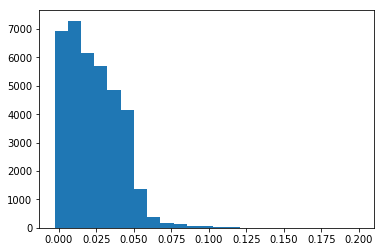

In [125]:
plt.hist(ints, bins=np.arange(min(ints), max(ints) + binwidth, binwidth))

In [126]:
binwidth = sig_std

(array([  1.70000000e+01,   1.32000000e+02,   3.75000000e+02,
          8.37000000e+02,   2.09900000e+03,   7.22200000e+03,
          2.06460000e+04,   1.20660000e+04,   5.82000000e+02,
          6.00000000e+00]),
 array([-11.86902749, -10.5527089 ,  -9.23639032,  -7.92007173,
         -6.60375314,  -5.28743455,  -3.97111597,  -2.65479738,
         -1.33847879,  -0.0221602 ,   1.29415838]),
 <a list of 10 Patch objects>)

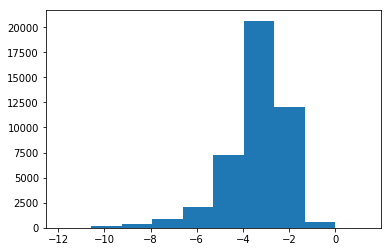

In [127]:
plt.hist(sigs, bins=np.arange(min(sigs), max(sigs) + binwidth, binwidth))

# NOTE

- log(significance) seems to be normally distributed with a spike of low-significance regions
- intactness is more Maxwell-Boltzmann and has a long tail in the high-end values...
- Instead of using standard deviations as bounds, use percentiles.

# Calculate Percentile

This will be hard coded, no front end-dev required for this section.

In [128]:
# Calculate percentile values (somewhat arbitrary and can be tweaked)
percentiles = [10, 25, 75, 90]

In [156]:
int_perc = [int_min]
sig_perc = [sig_min]
for p in percentiles:
    int_perc.append(np.percentile(ints, p))
    sig_perc.append(np.percentile(sigs, p))
    
int_perc.append(int_max)
sig_perc.append(sig_max)

In [157]:
# Percentile values for intacteness and significance
int_perc[1:-1], sig_perc[1:-1]

([0.0023439494272740318,
  0.0088213556813699599,
  0.035956818360068268,
  0.046790924545302641],
 [-4.9806691925864799,
  -3.9414584687798917,
  -2.5291295947066255,
  -1.9973631770277802])

(array([  3731.,   5596.,  18654.,   5596.,   3731.]),
 array([-0.00279234,  0.00234395,  0.00882136,  0.03595682,  0.04679092,
         0.19504152]),
 <a list of 5 Patch objects>)

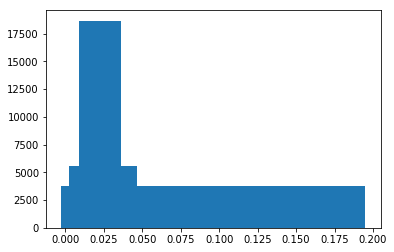

In [158]:
plt.hist(ints, bins=int_perc)

(array([  4399.,   6597.,  21990.,   6597.,   4399.]),
 array([-11.86902749,  -4.98066919,  -3.94145847,  -2.52912959,
         -1.99736318,   0.86734699]),
 <a list of 5 Patch objects>)

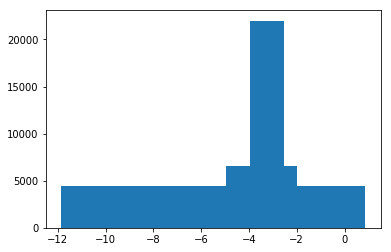

In [159]:
plt.hist(sigs, bins=sig_perc)

- Get a list of sub regions' in and sig values
- build a distribution
- pick bounds
- bucket into 'V. High', 'High', 'Normal', 'Low', 'V. Low'

# Example Widget

### To do

1. Get data from fetch
1. calculate percentiles
2. create buckets from these
3. count number in each bucket
4. calc percentage


HARD-CODED PERCENTILE BREAKS:

| metric | 10th percentile | 25th percentile | 75th percentile | 90th percentile | 
|--------|-----------------|-----------------|-----------------|-----------------|
| intactness | 0.002343949 | 0.008821356     | 0.03595682      | 0.04679092      |
| significance| -4.980669  |-3.941458        |-2.529130        |-1.997363        |


In [173]:
# Make the query and return data
def biodiversity_query(adm0=None, adm1=None):
    """Fetches total area, intactness and significance values for each region."""
                 
    if not adm0 and not adm1:
        print('Request for Global areas')
        sql = (f"SELECT iso AS location, sum(area) as area, "
               "sum(significance_total) AS sig, sum(intactness_total) AS int "
               f"FROM global_biodiversity_table "
               "GROUP BY iso")
        
    elif adm0 and not adm1:
        print('Request for country areas')
        sql = (f"SELECT iso, adm1 AS location, sum(area) as area, "
               "sum(significance_total) AS sig, sum(intactness_total) AS int "
               f"FROM global_biodiversity_table "
               f"WHERE iso = '{adm0}' "
               "GROUP BY iso, adm1")
        
    elif admin0 and adm1:
        print('Request adm1 areas')
        sql = (f"SELECT iso, adm1, adm2 AS location, sum(area) as area, "
               "sum(significance_total) AS sig, sum(intactness_total) AS int "
               f"FROM global_biodiversity_table "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1}"
               "GROUP BY iso, adm1, adm2")
    
    account = 'wri-01'
    urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

    sql = {"q": sql}
    r = requests.get(urlCarto, params=sql)
    print(r.url,'\n')
    data = r.json().get('rows')
    
    return data

In [117]:
# EXAMPLE: Global Level Case, Brazil

adm0 = None
adm1 = None
data = biodiversity_query(adm0=adm0, adm1=adm1)


# Query should return a data list where each element has the keys:


# {
#     "iso": "BRA",
#     "adm1": 14,
#     "adm2": None,
#     "area": 1266378688960.87,
#     "sig": 1818786398.88914,
#     "int": -891244028.230333
# }

# (see below)


Request for Global areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+GROUP+BY+iso 



In [69]:
"""NOTE significance is exponential and ranges from 0 to 1.73e9
        intactness is linear and ranges from 0.37e9 to -3.17e9"""

data[0:3]

[{'area': 22111665731.4525,
  'int': -43091664.7444239,
  'iso': 'BLZ',
  'sig': 186736529.119748},
 {'area': 140281129471.352,
  'int': -4773897473.97335,
  'iso': 'BGD',
  'sig': 117727281.708589},
 {'area': 7860417202.66774, 'int': 0, 'iso': 'ATF', 'sig': 86.335124714994}]

In [82]:
# Get percentile bounds for Intactness (this will be hardcoded)
int_perc[1:-1]

[0.00015267099387302624,
 0.0024074785194902158,
 0.022754608585611132,
 0.034339105523731803]

In [83]:
# Get percentile bounds for Significance (this will be hardcoded)
sig_perc[1:-1]

[-5.2646716264414586,
 -3.7595154633661956,
 -2.2457416116059994,
 -1.3721143303681893]

In [84]:
def getLocalStats(data, metric='int'):
    """ Calculates mean of data for a given metric.
        In the front end we would do both Intactness and Significance at the same time.
    """
    if metric == 'int':
        values = [-d.get('int')/d.get('area') for d in data if d.get('int')]
    elif metric == 'sig':
        values = [math.log(d.get('sig')/d.get('area'),10) for d in data if d.get('sig')]
    
    mean = np.mean(values)
#     std = np.std(values)
    
    return {'mean': mean, 'std': std}

In [203]:
def getHistogram(data):
    """
        Create the histogram using the sefined percentiles.
        Note that Intactness and SIgnificance percentile values are different.
    """
    
    metrics = ['int', 'sig']
    tmp = {}

    # For Intactness and Significance, count the number of loctaions
    # which fall into a given category
    for metric in metrics:
        
        categories = {

            'very high': {'counts': 0, 'percent': 0, 'locations': []},
            'high': {'counts': 0, 'percent': 0, 'locations': []},
            'normal': {'counts': 0, 'percent': 0, 'locations': []},
            'low': {'counts': 0, 'percent': 0, 'locations': []},
            'very low': {'counts': 0, 'percent': 0, 'locations': []}

        }
        
        # Run through each element of data and bin the value based on the percentiles.
        for d in data:
            if metric == 'int':
                value = -d.get(metric)/d.get('area')
                percentile = int_perc[1:-1]
                
            elif metric == 'sig' and d.get('sig'):
                value = math.log(d.get(metric)/d.get('area'))
                percentile = sig_perc[1:-1]

            if (value > percentile[3]):
                tmp_c = categories.get('very high').get('counts')
                categories['very high']['counts'] = tmp_c + 1
                
                categories['very high']['locations'].append(d.get('location'))
                
            elif (value > percentile[2]) and (value <= percentile[3]):
                tmp_c = categories.get('very high').get('counts')
                categories['high']['counts'] = tmp_c + 1
                
                categories['high']['locations'].append(d.get('location'))
                
            elif (value > percentile[1]) and (value <= percentile[2]):
                tmp_c = categories.get('normal').get('counts')
                categories['normal']['counts'] = tmp_c + 1
                
                categories['normal']['locations'].append(d.get('location'))
                
            elif (value > percentile[0]) and (value <= percentile[1]):
                tmp_c = categories.get('low').get('counts')
                categories['low']['counts'] = tmp_c + 1
                
                categories['low']['locations'].append(d.get('location'))
                
            elif (value <= percentile[0]):
                tmp_c = categories.get('very low').get('counts')
                categories['very low']['counts'] = tmp_c + 1
                
                categories['very low']['locations'].append(d.get('location'))
        
        #  the total of locations.
        total = len(data)
        
        # Calclate the percentage.
        for k,v in categories.items():
            tmp_val = v.get('counts')
            categories[k]['percent'] = round(100 * tmp_val / total, 1) 
        
        tmp[metric] = categories
    
    return tmp


In [212]:
# Country Level example: Australia

adm0 = 'AUS'
adm1 = None
metric = 'Intactness'

#Get raw data
widgetData = biodiversity_query(adm0=adm0, adm1=adm1)

pprint(getHistogram(widgetData))

# Note that the list of regions are stored in the location key for each category.

Request for country areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1+AS+location%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+WHERE+iso+%3D+%27AUS%27+GROUP+BY+iso%2C+adm1 

{'int': {'high': {'counts': 0, 'locations': [], 'percent': 0.0},
         'low': {'counts': 4, 'locations': [5, 11, 9, 8], 'percent': 36.4},
         'normal': {'counts': 2, 'locations': [10, 2], 'percent': 18.2},
         'very high': {'counts': 0, 'locations': [], 'percent': 0.0},
         'very low': {'counts': 5,
                      'locations': [3, 7, 4, 1, 6],
                      'percent': 45.5}},
 'sig': {'high': {'counts': 0, 'locations': [], 'percent': 0.0},
         'low': {'counts': 2, 'locations': [4, 1], 'percent': 18.2},
         'normal': {'counts': 0, 'locations': [], 'percent': 0.0},
         'very high': {'counts': 0, 'locations': [], 'percent': 0.0},
         'very low': {'counts': 9,
          

# Dynamic Sentence

The widget also requires a dynamic sentence which depends on user selected settings.

In [237]:
def getSentence(hist, selected, unit, metric): 
        
    if(metric == 'int'):
        label = 'intacteness'
    elif(metric == 'sig'):
        label = 'signficance'

    # Get location names from config
    areaId_to_name = None
    if adm2:
        tmp = get_admin2_json(iso=adm0, adm1=adm1)
        areaId_to_name ={}
        for row in tmp:
            areaId_to_name[row.get('adm2')] = row.get('name')
    if adm1 and not adm2:
        tmp = get_admin1_json(iso=adm0)
        areaId_to_name={}
        for row in tmp:
            areaId_to_name[row.get('adm1')] = row.get('name')

    # Create correct phase for location
    if not adm0 and  not adm1 and not adm2:
        title = ("countries globally")
    if adm0 and not adm1 and not adm2:
        title = (f"regions in {iso_to_countries[adm0]}")
    if adm0 and adm1 and not adm2: 
        title = (f"subregions in {areaId_to_name[adm1]}")
        
    

    if(unit == 'percent'):
        if hist[metric][selected][unit] == 0:
            value = '0'
        
        print("")
        print(f"Around {value}% of {title} have a ",end="")
        print(f"{selected} degree of biodiversity {label} on average.", end="")
        
    else:
        if hist[metric][selected][unit] == 0:
            value = 'no'
            
        print("")
        print(f"There are {value} {title} with a ",end="")
        print(f"{selected} degree of biodiversity {label} on average.", end="")



# Examples

In [225]:
categories = ['very high', 'very high', 'normal', 'low', 'very low']

In [226]:
adm0 = 'IDN'
adm1 = None
metric = 'int'
unit = 'percent'
category = categories[2]

data = biodiversity_query(adm0=adm0, adm1=adm1)
hist = getHistogram(data)
getSentence(hist, category, unit, metric)


Request for country areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1+AS+location%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+WHERE+iso+%3D+%27IDN%27+GROUP+BY+iso%2C+adm1 


Around 27.3% of regions in Indonesia have a normal degree of biodiversity intacteness on average.

In [234]:
adm0 = 'COD'
adm1 = None
metric = 'int'
unit = 'counts'
category = categories[4]

data = biodiversity_query(adm0=adm0, adm1=adm1)
hist = getHistogram(data)
getSentence(hist, category, unit, metric)

Request for country areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1+AS+location%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+WHERE+iso+%3D+%27COD%27+GROUP+BY+iso%2C+adm1 


There are 21 regions in Democratic Republic of the Congo with a very low degree of biodiversity intacteness on average.

In [231]:
adm0 = 'AUS'
adm1 = None
metric = 'sig'
unit = 'percent'
category = categories[3]

data = biodiversity_query(adm0=adm0, adm1=adm1)
hist = getHistogram(data)
getSentence(hist, category, unit ,metric)

Request for country areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1+AS+location%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+WHERE+iso+%3D+%27AUS%27+GROUP+BY+iso%2C+adm1 


Around 18.2% of regions in Australia have a low degree of biodiversity signficance on average.

In [222]:
adm0 = None
adm1 = None
metric = 'sig'
unit = 'counts'
category = categories[0]

data = biodiversity_query(adm0=adm0, adm1=adm1)
hist = getHistogram(data)
getSentence(hist, category, unit, metric)

Request for Global areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso+AS+location%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+GROUP+BY+iso 


There are 19 countries globally with a low degree of biodiversity signficance on average.

In [238]:
adm0 = None
adm1 = None
metric = 'int'
unit = 'counts'
category = categories[0]


data = biodiversity_query(adm0=adm0, adm1=adm1)
hist = getHistogram(data)
getSentence(hist, category, unit, metric)

Request for Global areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso+AS+location%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+GROUP+BY+iso 


Globally, there are no countries with a very high degree of biodiversity intacteness on average.